## K Nearest Neighbors


Neighbors-based classification is a type of *instance-based learning* or *lazy learning*: it does not attempt to construct a general internal model (using a boundary), but simply stores instances of the training data and defers the decision to generalize until a new test instance in encountered. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

<img src="./KNN_neighbors.png"  width=50% />


### Import the libraries and dataset

Before we import the data, let's load the necessary libraries:

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics

pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore") 

In the first notebook, we looked at the data on customer churn for a telecom operator. 
- We will reload the same dataset into a `DataFrame` named **"df"** using once more the function  `read_csv()` ([Check the pandas read_csv() documentation if needed](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)). 
- To get acquainted with our data, let’s look at the first 5 entries using `head()`
- Check the dimensionality of the data using `shape`
- The dataset is provided in your Lab folder. 

In [9]:
# Read the data from the telecom_churn.csv file (found in the Lab folder) using the 
# pd.read_csv() function from pandas into a variable named "df" 
# Print the dimensionality (shape) of the df DataFrame
# Show the first 5 rows of df using the function head()

df = pd.read_csv("./telecom_churn.csv")
print(df.shape)
df.head()

(3333, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Can you find the target variable we are trying to predict? 

### Split to input variables and class vector 

KNN follows a similar workflow to other supervised models and is one of the easier models to use. We first start by setting the `X` matrix (input features) and `y` vector (class target):

In [10]:
# Common step across all Supervised Machine Learning models in Python

# Store the feature data into a new variable named "X" - Extract all columns 
# **except** from the label column using either indexing (.loc / .iloc) 
# or df.drop() with axis=1

X = df.drop('Churn', axis=1)

# Store the target data (label/class column) into a new variable named "y"
# Extract only the label (class) column

y = df['Churn']


# Print the dimensions (using "shape") for both X and y 
print ("X dimensions: ", X.shape)
print ("y dimensions: ", y.shape)

X dimensions:  (3333, 19)
y dimensions:  (3333,)


Just for ease throughout today's notebook activity, let's work only with the numerical features: 

In [11]:
numerical_features = list(set(df.columns)- set(
        [
            "State",
            "International plan",
            "Voice mail plan",
            "Area code",
            "Churn",
            "Customer service calls",
        ]
    )
)

X = X[numerical_features]

### Investigate the class frequencies

An important aspect to understand before applying any classification algorithm is how the output labels are distributed. Are they evenly distributed or not? Imbalances in distribution of labels can often lead to poor classification results for the minority class even if the classification results for the majority class are very good.

#### 1. Tabular format - frequency table

In [12]:
# Use the function value_counts() on the y variable 
# in order to check the distribution of the binary class 

y.value_counts()

False    2850
True      483
Name: Churn, dtype: int64

By default, the entries in the output are sorted from the most to the least frequently-occurring values.

- What do you observe?? 

In our case, the data are **not balanced**; that is, our two target classes, churned and non-churned customers, are not represented equally in the dataset. As we will see in the following section, this fact may imply some restrictions on measuring the classification performance.

#### 2. Visualization

The bar plot is a graphical representation of the frequency table. The easiest way to create it is to use the `seaborn`'s function [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html). There is another function in `seaborn` that is somewhat confusingly called [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) and is mostly used for representation of some basic statistics of a numerical variable grouped by a categorical feature. Let's plot the distributions for categorical variables:

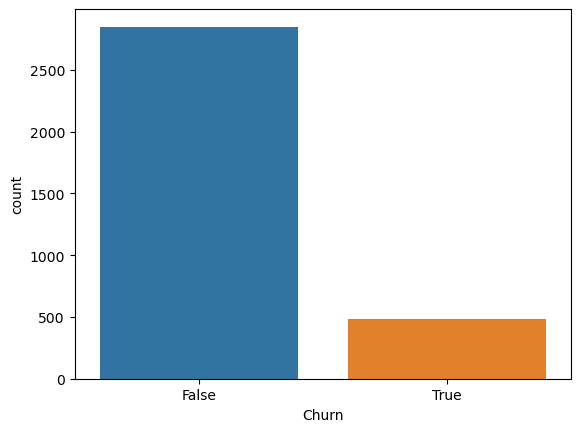

In [13]:
# Use the sns.countplot() function from seaborn to plot 
# the feature "Churn" (argument x="Churn") from df (data=df)

sns.countplot(x="Churn", data=df);

The chart above vividly illustrates the **imbalance** in our target variable. 

### Mapping (encoding) the categorical variable

In order for the class variable to be in machine-readable form and ready to be used by ML models, it needs to be encoded in a numerical format. `LabelEncoder` from `sklearn` can be used to encode target labels with value between `0` and `n_classes-1`. 

**This transformer should be used to encode target values, i.e. y, and not the input X** (in which case, we can use One Hot Encoding or other ways of encoding). Read more about [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) and [Transforming the prediction variable(y)](https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets)

In [14]:
# Convert the categorical values into numbers using the label encoder from sklearn
# from True / False to integers 1 and 0.

# Initialise a LabelEncoder object
le = LabelEncoder()

# Fit label encoder, return encoded labels and assign back to the class column of y
# The fit_transform() function takes a categorical column and converts/maps it to numerical values.
y = le.fit_transform(y)

In [15]:
print(le.classes_)

[False  True]


In [16]:
print(le.inverse_transform(y))

[False False False ... False False False]


In [17]:
pd.DataFrame(y).value_counts()

0    2850
1     483
dtype: int64

## Supervised Learning - Classification

For every classification model built with scikit-learn, we will follow four main steps:

1. Building the classification model (using either default, pre-defined or optimized parameters)
2. Training the model
3. Testing the model
4. Performance evaluation using various metrics.

### Train-Test Split

Training and testing a classification model on the same dataset is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data (poor generalisation). To use different datasets for training and testing, we need to split our dataset into two disjoint sets: train and test (Holdout method).

Use `sklearn`’s `train_test_split()` function to randomly split the data into train and test sets (visit the [train_test_split documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and the  [model cross-validation documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)). Typically, 20% test size seems reasonable enough for checking the performance of models.

**Note: it’s good practice to split the train and test sets before doing any feature engineering and/or scaling to avoid data leakage!!**


In [18]:
# Use the train_test_split() function from sklearn and pass the following arguments: 
# (1) the X matrix (2) the y vector (3) test_size=0.2 
# (4) stratify=y (5) random_state=1 (for result reproducibility)
# Store the results into the new variables X_train, X_test, y_train, y_test (simultaneously)
# Note: when working with imbalances, it is important to stratify y when doing a train_test_split()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# Print the results of X_train, X_test, y_train, y_test 
# Do the X and y variables for train and test respectively match? 

print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

Shape of x_train and y_train:  (2666, 14) (2666,)
Shape of x_test and y_test:  (667, 14) (667,)


### Scaling 

- What do you observe when visualizing the following plot? 

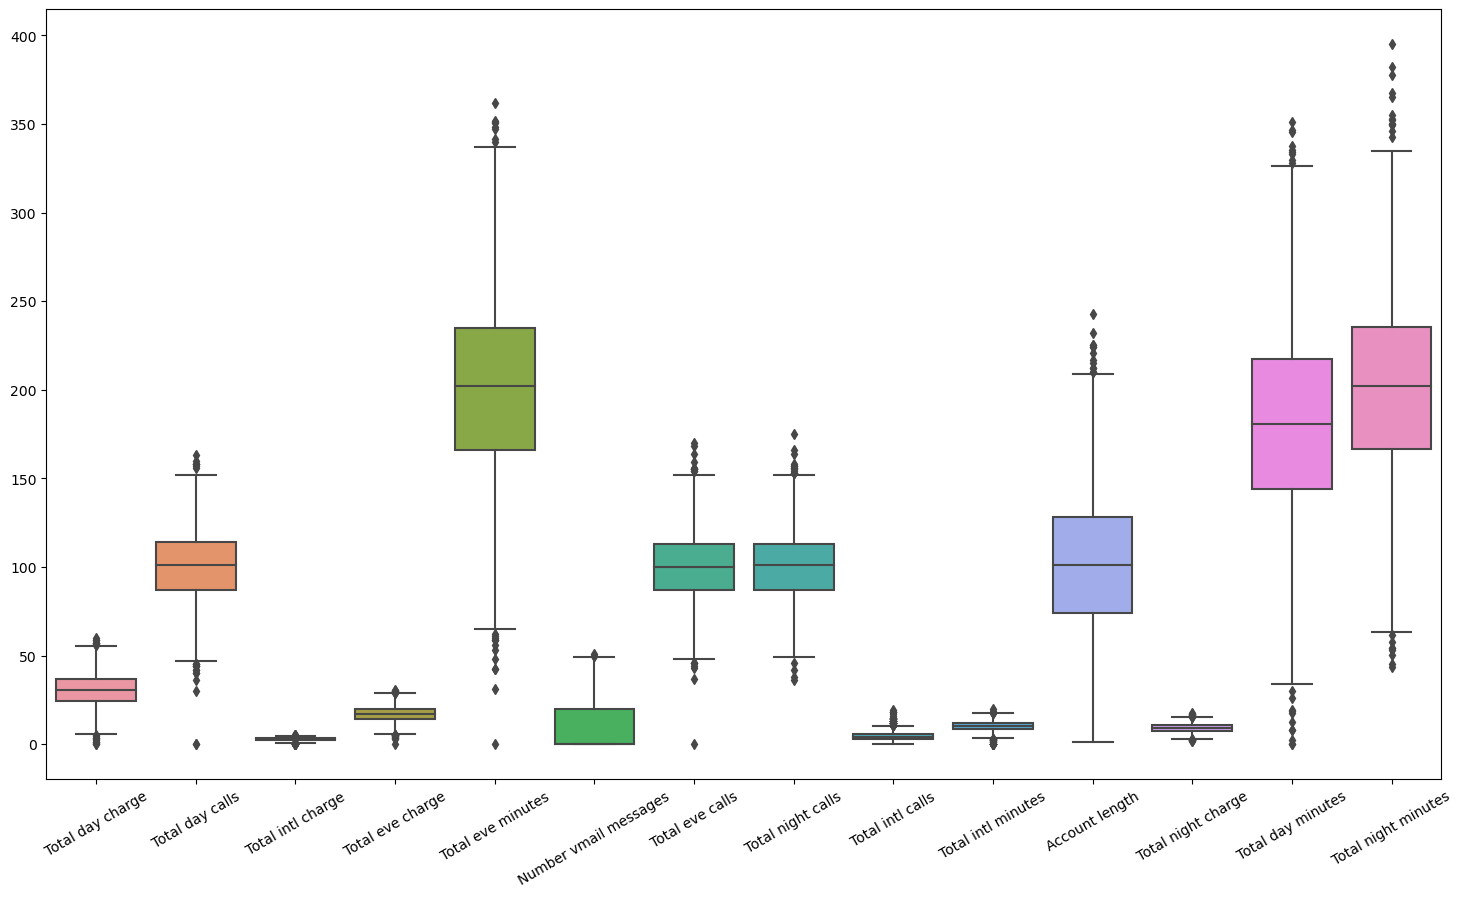

In [19]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(data=X_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

Prior to feeding our data to any other supervised or unsupervised learning technique, we need to **scale** our data. For this, we will subtract the mean from each variable and divide it by its standard deviation. All of this can be done with `StandardScaler`.

**NOTE: We should only fit the scaler on the train set and use it to transform the test set to avoid data leakage.** 

In [20]:
# Instantiate the StandardScaler() from sklearn 
# Store into a variable named "scaler" 

scaler = StandardScaler()  

# Fit the scaler on the X_train data - Use the scaler.fit_transform() on the X_train set 
# Assign the result back to the variable X_train 

X_train = scaler.fit_transform(X_train)

# Transform (do not fit!) the test dataset using the (fitted) scaler - 
# Use the scaler.transform() on the X_test
# Assign the result back to the variable X_test

X_test  = scaler.transform(X_test)

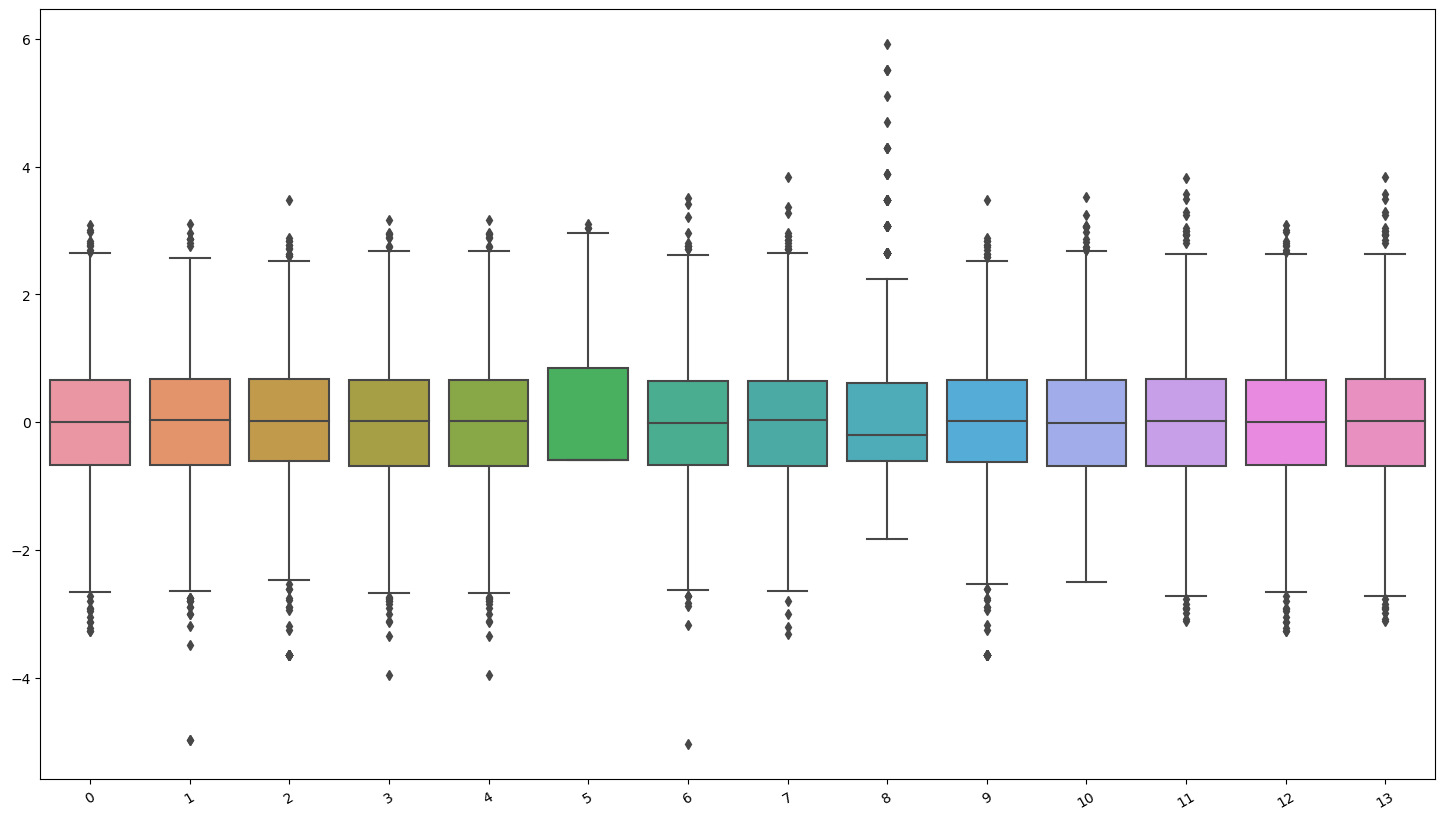

In [21]:
# What do you observe when running the code below? 

plt.figure(figsize=(18,10))
ax = sns.boxplot(data= X_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

### Train, optimise and test a KNN algorithm with scikit-learn

`scikit-learn` implements two different nearest neighbors classifiers: 
- `KNeighborsClassifier` implements learning based on the nearest neighbors of each query point, where is an integer value specified by the user. 
- `RadiusNeighborsClassifier` implements learning based on the number of neighbors within a fixed radius of each training point, where is a floating-point value specified by the user. 
The k-neighbors classification in `KNeighborsClassifier` is the most commonly used technique.

The `KNeighborsClassifier` object allows you to set the value of K using the `n_neighbors` parameter (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). 

Reminder: for every classification model built with `scikit-learn`, we will follow four main steps: 
- 1) Building the classification model (using either default, pre-defined or optimised parameters), 
- 2) Training the model, 
- 3) Testing the model, and 
- 4) Performance evaluation using various metrics.



In [22]:
# Step 1 - Instantiate the KNeighborsClassifier() classifier using the default parameters 
# default parameters: do not pass any parameter values in KNeighborsClassifier() 
# Assign the result into a new variable named "knn"

knn = KNeighborsClassifier()

# Step 2 - Fit the knn model to the training set (use knn.fit())
# Pass as arguments the train matrix X_train and the class vec y_train 
# No need to assign it into a new variable

knn.fit(X_train, y_train)

# Step 3 - Predict the test data using the knn model (use knn.predict())
# Pass as argument only the test matrix X_test
# Save the prediction output into a new variable "y_pred"

y_pred = knn.predict(X_test)

# Step 4 - Print the final overall accuracy for the test set using metrics.accuracy_score()
# Pass as parameters the actual values from y_test and the predicted values from y_pred

print('Test set accuracy: ', metrics.accuracy_score(y_test, y_pred))

Test set accuracy:  0.8605697151424287


In [23]:
# Print the confusion_matrix for the test set using metrics.confusion_matrix()
# Pass as parameters the actual values from y_test and the predicted values from y_pred

print(metrics.confusion_matrix(y_test, y_pred))

[[559  11]
 [ 82  15]]


In [24]:
# Print the classification_report for the test set using metrics.classification_report()
# Pass as parameters the actual values from y_test and the predicted values from y_pred

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       570
           1       0.58      0.15      0.24        97

    accuracy                           0.86       667
   macro avg       0.72      0.57      0.58       667
weighted avg       0.83      0.86      0.82       667



### Hyperparameter tuning

#### GridSearchCV 

All classification models have a set of parameters that need to be optimised (tuned). Grid search is a process that searches exhaustively through a manually specified subset of the hyperparameter space. `GridSearchCV` ([link to sklearn GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) implements the most obvious way of finding an optimal value for anything — it simply tries all the possible values (that you pass) one at a time and returns which one yielded the best model results, based on the scoring that you want, such as accuracy on the test set.

Using `GridSearchCV` is also very simple, with a few customizable parameters. Here’s a breakdown of them:

1. `estimator`: the model you are using. 
2. `params_grid`: the dictionary object that holds the hyperparameters of the model you want to test.
3. **`scoring`: evaluation metric** 
<br>(See the [various available scoring options](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) or how to [define your scoring strategy](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring))
4. `cv`: number of cross-validation for each set of hyperparameters
5. `verbose`: The higher, the more messages are going to be printed.
6. `n_jobs`: Number of jobs to run in parallel. 
7. `pre_dispatch`: controls the number of jobs that can be done in parallel (to avoid memory issues)
8. `iid`: assumes data is identically independently distributed. Default is False.
9. `refit`: once best params are found, refit the estimator
10. `error_score`: value to assign to the score if an error happens when fitting the estimator
11. `return_train_score`: include train scores in `cv_results_`


#### KNN hyperparameter options: 

- The optimal choice for the value *K* is highly data-dependent: in general a larger *K* suppresses the effects of noise, but makes the classification boundaries less distinct. Rather than trying one-by-one predefined values of *K*, we can automate this process. The scikit-learn library provides the grid search function `GridSearchCV` ([link to sklearn GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)), which allows to exhaustively search for the optimum combination of parameters by evaluating models trained with a particular algorithm with all provided parameter combinations. Further details and examples on grid search with scikit-learn can be found at ["Tuning the hyper-parameters of an estimator"](http://scikit-learn.org/stable/modules/grid_search.html). 

- The basic nearest neighbors classification uses *uniform* weights: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the `weights` keyword. The default value, `weights = 'uniform'`, assigns uniform weights to each neighbor. `weights = 'distance'` assigns weights proportional to **the inverse of the distance** from the query point. Alternatively, a user-defined function of the distance can be supplied to compute the weights.

- `metric` which refers to how the distance of neighboring points is chosen from the unknown point. Because modeling is generally done in more than 3 dimensions, this can be difficult to visualize.

In [25]:
# Create the dictionary of model hyperparameters
n_neighbors = np.arange(1, 101, 2)  
weights     = ['uniform', 'distance']
metric      = ['minkowski','euclidean','manhattan']

# Convert to dictionary
knn_param_grid = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)
knn_param_grid

{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]),
 'weights': ['uniform', 'distance'],
 'metric': ['minkowski', 'euclidean', 'manhattan']}

Use the `GridSearchCV` function with the validation technique of your choice (in this example, for instance, 10-fold cross-validation can been applied) to search for the optimal hyperparameters of KNN:

In [26]:
# Grid search with 10-fold cross-validation using a dictionary of parameters
# Optimise and build the model with GridSearchCV
gridCV = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10)
gridCV.fit(X_train, y_train) 

# Report the optimal parameters
bestNeighbors = gridCV.best_params_['n_neighbors']
bestWeight = gridCV.best_params_['weights']
bestMetric = gridCV.best_params_['metric']

print("Best parameters: n_neighbors=", bestNeighbors)
print("Best parameters: weights =", bestWeight)
print("Best parameters: metric =", bestMetric)

Best parameters: n_neighbors= 9
Best parameters: weights = distance
Best parameters: metric = manhattan


Some useful functions: 

In [27]:
print(gridCV.best_score_)
print(gridCV.best_params_)
print(gridCV.best_estimator_)

0.8844738250119681
{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')


In [28]:
# The results of cross-validation for various hyperparameter combinations 
pd.DataFrame(gridCV.cv_results_)[['mean_test_score','params']]

,mean_test_score,params
0,0.816196,"{'metric': 'minkowski', 'n_neighbors': 1, 'wei..."
1,0.816196,"{'metric': 'minkowski', 'n_neighbors': 1, 'wei..."
2,0.867590,"{'metric': 'minkowski', 'n_neighbors': 3, 'wei..."
3,0.866088,"{'metric': 'minkowski', 'n_neighbors': 3, 'wei..."
4,0.876596,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei..."
...,...,...
295,0.861967,"{'metric': 'manhattan', 'n_neighbors': 95, 'we..."
296,0.859717,"{'metric': 'manhattan', 'n_neighbors': 97, 'we..."
297,0.861592,"{'metric': 'manhattan', 'n_neighbors': 97, 'we..."
298,0.859342,"{'metric': 'manhattan', 'n_neighbors': 99, 'we..."


Let's create the final optimized model using the best parameters as detected from the exhaustive grid search: 

In [29]:
# Build the classifier using the optimal parameters detected by grid search

knn_opt = KNeighborsClassifier(n_neighbors=bestNeighbors, 
                               weights = bestWeight, 
                               metric = bestMetric
                              )

# Fit to the training set 
knn_opt.fit(X_train, y_train)

# Predict the test data
y_pred = knn_opt.predict(X_test)

# Report the final overall accuracy
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_train))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_pred))

Training set accuracy:  1.0
Test set accuracy:  0.8740629685157422


In [30]:
# Checking performance our model with classification report.
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       570
           1       0.84      0.16      0.28        97

    accuracy                           0.87       667
   macro avg       0.86      0.58      0.60       667
weighted avg       0.87      0.87      0.84       667



### Bonus exercise - RandomSearchCV

Reducing computational expense with randomized search on hyperparameters using the `RandomSearchCV` from `sklearn` ([link here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)).

In contrast to `GridSearchCV`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by `n_iter`.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In [31]:
from sklearn.model_selection import RandomizedSearchCV

In [32]:
# Optimise and build the model with RandomizedSearchCV
randomCV = RandomizedSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10)
randomCV.fit(X_train, y_train) 

# Report the optimal parameters
bestNeighbors = randomCV.best_params_['n_neighbors']
bestWeight    = randomCV.best_params_['weights']
bestMetric    = randomCV.best_params_['metric']

print("Best parameters: n_neighbors=", bestNeighbors)
print("Best parameters: weights =",    bestWeight)
print("Best parameters: metric =",     bestMetric)

Best parameters: n_neighbors= 7
Best parameters: weights = distance
Best parameters: metric = minkowski


In [33]:
# Build the classifier using the default parameters detected by grid search

knn_opt = KNeighborsClassifier(n_neighbors=bestNeighbors, 
                               weights = bestWeight, 
                               metric = bestMetric)

# Fit to the training set 
knn_opt.fit(X_train, y_train)

# Predict the test data
y_pred = knn_opt.predict(X_test)

# Report the final overall accuracy
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_train))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_pred))

Training set accuracy:  1.0
Test set accuracy:  0.8710644677661169


In [34]:
# Checking performance our model with classification report.
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       570
           1       0.82      0.14      0.25        97

    accuracy                           0.87       667
   macro avg       0.85      0.57      0.59       667
weighted avg       0.87      0.87      0.83       667

